# The equation

$$
-\Delta u = f,
$$
where 
$$
f(x, y) = -8 \pi^2 \sin(2\pi  x) \sin(2 \pi y),
$$
and $u = 0$ on the boundary.

This documents does the following:

1. Compute the 'prior' FEM solution $u_h$ before taking measurements.
2. Generate observations by drawing from the prior FEM solution and adding model mispecification term and observation noise.
3. Estimate the parameters for the misspecification term $(\sigma_k, l_k)$ and the scaling term ($\rho$).
4. Compute the posterior estimate of $u_h$, conditioned on the data and inspect the uncertainty compared to the uncertainty given by the prior solution distributed as $\mathcal{N}(m_u^\theta, C_u^\theta)$

Import the libraries

In [28]:
import numpy as np
from firedrake import UnitSquareMesh, FunctionSpace, TrialFunction, TestFunction
from firedrake import SpatialCoordinate, dx, pi, sin, dot, grad, DirichletBC
from firedrake import assemble, Function, solve
from firedrake import norms

import stat_fem
import matplotlib.pyplot as plt

Make the mesh and necessary Firedrake objects to express the problem in the variational form. The mesh is 100 points by 100 points.

In [29]:
nx = 100

mesh = UnitSquareMesh(nx - 1, nx - 1)
V = FunctionSpace(mesh, "CG", 1)

u = TrialFunction(V)
v = TestFunction(V)

f = Function(V)
x = SpatialCoordinate(mesh)
f.interpolate(-(8 * pi * pi) * sin(x[0] * pi * 2) * sin(x[1] * pi * 2))

a = (dot(grad(v), grad(u))) * dx
L = f * v * dx

bc = DirichletBC(V, 0., "on_boundary")

A = assemble(a, bcs=bc)

b = assemble(L)

u = Function(V)

Define observation locations (a grid)

In [49]:
datagrid = 6
ndata = datagrid ** 2
x_data = np.zeros((ndata, 2))

count = 0
for i in range(datagrid):
    for j in range(datagrid):
        x_data[count, 0] = float(i + 1) / float(datagrid + 1)
        x_data[count, 1] = float(j + 1) / float(datagrid + 1)
        count += 1

# Specifying the uncertainty in the forcing function

In [50]:
log_sigma_f = np.log(1e-2)
log_l_f = np.log(0.2)

G = stat_fem.ForcingCovariance(V, log_sigma_f, log_l_f, cutoff=1.e-4)
G.assemble()

Max nonzero elements in a row: 97


# The prior FEM solution

We use Firedrake to solve for $u_h$ and plot the solution.

Text(0.5, 1.0, 'Prior FEM solution (mean)')

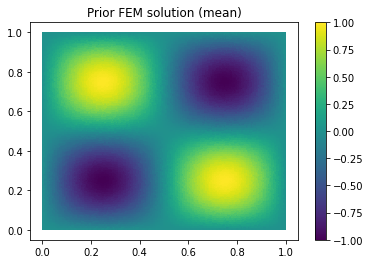

In [31]:
solve(A, u, b) # firedrake solve

plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              u.vector().dat.data, vmin=-1, vmax=1)
plt.colorbar()
plt.title("Prior FEM solution (mean)")

# Perform data measurements

We will take the solution $u_h$ above on a grid of points and add the mis-specification term as well as the observation error. The plots shows the prior FEM solution alongside the measurements in the grid locations.

To make the misspecification visible, I've made the mis-specification error relatively large and with fairly long lengthscale, whilst setting the measurement error quite low.

Text(0.5, 1.0, 'Prior FEM solution and observed data')

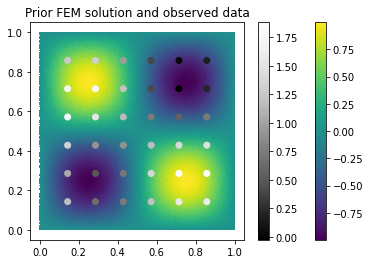

In [46]:
# the nugget (measurement noise)
sigma_y = 5.e-3

# the mis-specification term
sigma_k = 1.e0
lengthscale_k = 0.5
rho = 1

        
interp_matrix = stat_fem.InterpolationMatrix.InterpolationMatrix(V, x_data)
C_u = stat_fem.solving_utils.interp_covariance_to_data(interp_matrix, G, A, interp_matrix)
        
f_error = np.random.multivariate_normal(np.zeros(ndata), C_u)     

cov_matrix = stat_fem.covariance_functions.sqexp(x_data, x_data, sigma=np.log(sigma_k), l=np.log(lengthscale_k))
correlated_noise = np.random.multivariate_normal(np.zeros(ndata), cov_matrix)

measurement_noise = np.random.normal(scale=sigma_y, size=ndata)


y = rho * (interp_matrix.interp_mesh_to_data(u.vector()) + f_error) + correlated_noise + measurement_noise


plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              u.vector().dat.data)
plt.colorbar()
plt.scatter(x_data[:, 0], x_data[:, 1], c=y, cmap="Greys_r")
plt.colorbar()
plt.title("Prior FEM solution and observed data")

# Estimate the parameters

We estimate $\rho$, $\sigma_k$, and $\ell_k$. We assume that the measurement noise is known.

In [51]:
obs_data = stat_fem.ObsData(x_data, y, sigma_y)
ls = stat_fem.estimate_params_MAP(A, b, G, obs_data)

In [52]:
print(f"MAP estimates on log-scale (ρ, σ_k, l_k): {np.exp(ls.params)}")
print(f"Actual input parameters on log-scale (ρ, σ_k, l_k): {np.array([rho, sigma_k, lengthscale_k])}")

MAP estimates on log-scale (ρ, σ_k, l_k): [0.9927655  1.11623828 0.51795803]
Actual input parameters on log-scale (ρ, σ_k, l_k): [1.  1.  0.5]


# Posterior estimates

## Posterior mean of $u_h$

Below is the plot of the posterior mean of $u_h$ in the mesh space.

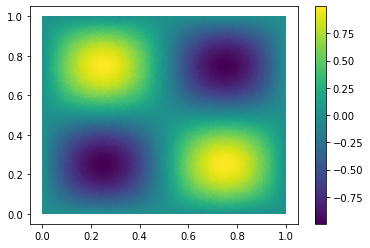

In [53]:
muy = Function(V)
ls.solve_posterior(muy)

plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              muy.vector().dat.data)
plt.colorbar()

### Absolute difference between the posterior mean of $u_h$ and the prior mean.

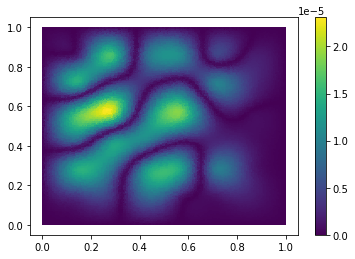

In [54]:
plt.tripcolor(mesh.coordinates.vector().dat.data[:, 0],
              mesh.coordinates.vector().dat.data[:, 1],
              np.abs(muy.vector().dat.data - u.vector().dat.data))
plt.colorbar()

## Marginal variance at grid locations before and after taking measurements

In [55]:
post_mu_d, post_Cu_d = ls.solve_posterior_covariance()
prior_mu_d, prior_Cu_d = ls.solve_prior()

Text(0.5, 1.0, 'Posterior variance')

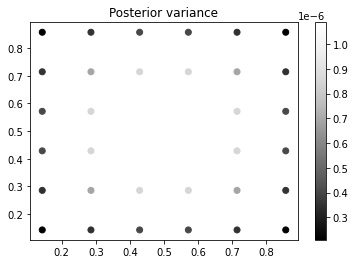

In [56]:
plt.scatter(x_data[:, 0], x_data[:, 1], c=np.diag(post_Cu_d), cmap="Greys_r")
plt.colorbar()
plt.title("Posterior variance")

Text(0.5, 1.0, 'Prior variance')

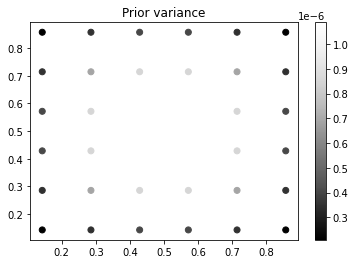

In [57]:
plt.scatter(x_data[:, 0], x_data[:, 1], c=np.diag(prior_Cu_d), cmap="Greys_r")
plt.colorbar()
plt.title("Prior variance")

Text(0.5, 1.0, 'Abs difference of variance (prior vs posterior)')

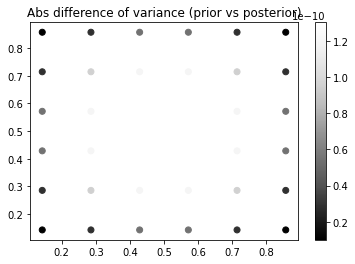

In [58]:
plt.scatter(x_data[:, 0], x_data[:, 1], c=np.abs(np.diag(prior_Cu_d) - np.diag(post_Cu_d)), cmap="Greys_r")
plt.colorbar()
plt.title("Abs difference of variance (prior vs posterior)")

# Remarks

1. The MAP estimates seem reasonable (uniform priors have been used)
2. The posterior mean is not too different from the prior mean: one observation per location is perhaps not enough to significantly inform the posterior.
3. The same is true for the marginal variance at observation locations: not much difference between the prior and the posterior